In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3 # This means it's a rgb image which have 3 channels

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5712 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 3 1 1 1 0 0 3 1 3 2 1 3 2 2 1 1 2 1 0 2 2 3 3 2 3 1 3 1 1 0 3]


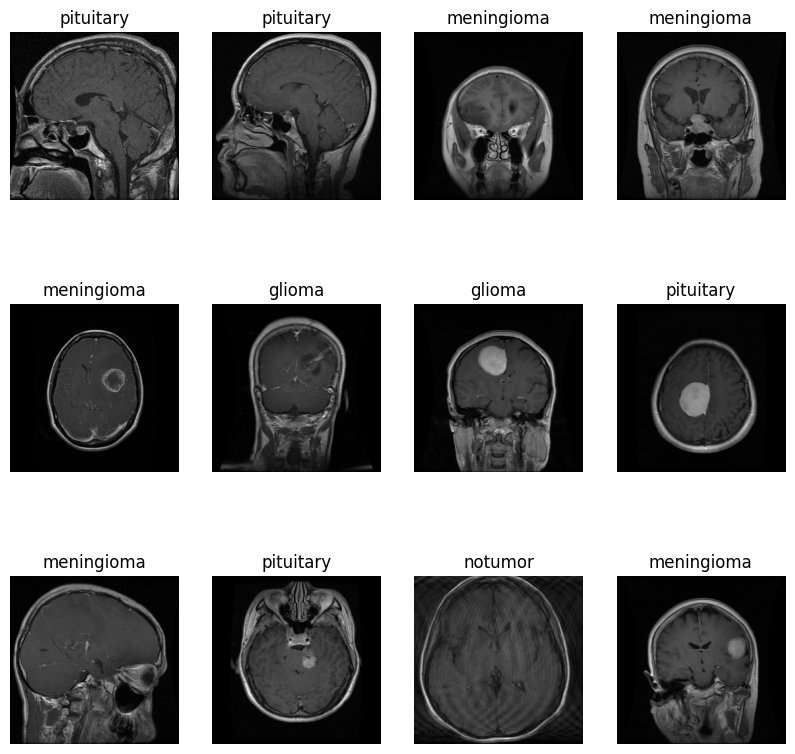

In [6]:
plt.figure(figsize=(10,10))

for image_batch, lables_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')
        
plt.show()

In [7]:
def get_partition_data(ds, train_split = 0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_split + val_split) == 1
    ds_size = len(dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [8]:
train_ds, test_ds, val_ds= get_partition_data(dataset)

In [9]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

143
19
17


In [10]:
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(0.1 / 256)
])

In [12]:
data_augmentation  = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
# adding early stoping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [15]:
from tensorflow.keras import models, layers
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=4
def build_model(hp):
    units = hp.Int('units', min_value=8, max_value=128, step=8)
    model = models.Sequential([
        resize_and_rescale,
        layers.Conv2D(filters=units, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=units, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=units, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=units, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(units=units, activation='relu'),
        layers.Dense(units=units, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(n_classes, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   metrics=['accuracy']
                   )

    return model

In [16]:
import keras_tuner as kt
tuner = kt.RandomSearch(build_model,
                       objective='val_accuracy',
                       max_trials=5,
                       directory='mydr',
                       project_name='tune')

In [17]:
tuner.search(train_ds,epochs=5,validation_data=val_ds)

Trial 5 Complete [01h 10m 48s]
val_accuracy: 0.7738970518112183

Best val_accuracy So Far: 0.814338207244873
Total elapsed time: 03h 52m 07s


In [18]:
import keras_tuner as kt
tuner = kt.RandomSearch(build_model,
                       objective='val_accuracy',
                       max_trials=5,
                       directory='mydr',
                       project_name='tune')

In [19]:
model =tuner.get_best_models(num_models=1)[0]

In [20]:
history = model.fit(train_ds,batch_size=BATCH_SIZE,epochs=10,callbacks=callback,initial_epoch=5,validation_data=val_ds)

Epoch 6/10
143/143 [==============================] - 753s 5s/step - loss: 0.5605 - accuracy: 0.7932 - val_loss: 0.4590 - val_accuracy: 0.8401
Epoch 7/10
143/143 [==============================] - 758s 5s/step - loss: 0.5264 - accuracy: 0.8002 - val_loss: 0.4503 - val_accuracy: 0.8419
Epoch 8/10
143/143 [==============================] - 751s 5s/step - loss: 0.4925 - accuracy: 0.8175 - val_loss: 0.4018 - val_accuracy: 0.8438
Epoch 9/10
143/143 [==============================] - 769s 5s/step - loss: 0.4513 - accuracy: 0.8368 - val_loss: 0.4424 - val_accuracy: 0.8125
Epoch 10/10
143/143 [==============================] - 750s 5s/step - loss: 0.4187 - accuracy: 0.8493 - val_loss: 0.3457 - val_accuracy: 0.8732


In [21]:
model.evaluate(test_ds)

19/19 [==============================] - 34s 1s/step - loss: 0.3208 - accuracy: 0.8716


[0.32081425189971924, 0.8716216087341309]

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

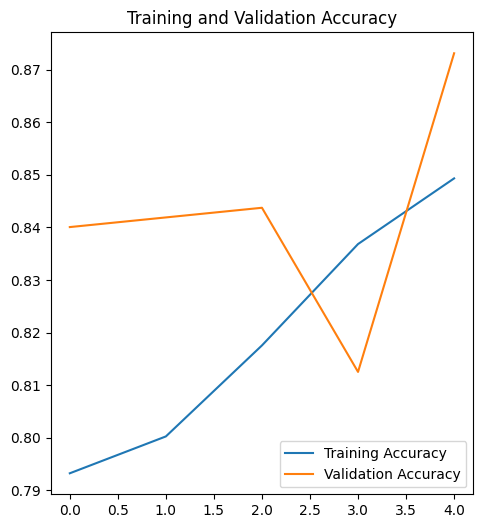

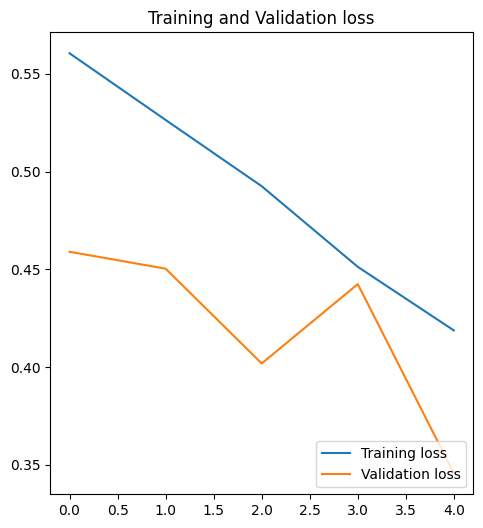

In [23]:
Epochs = len(acc)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc, label='Training Accuracy')
plt.plot(range(Epochs),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(Epochs),loss, label='Training loss')
plt.plot(range(Epochs),val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

In [24]:
model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 61ms/step


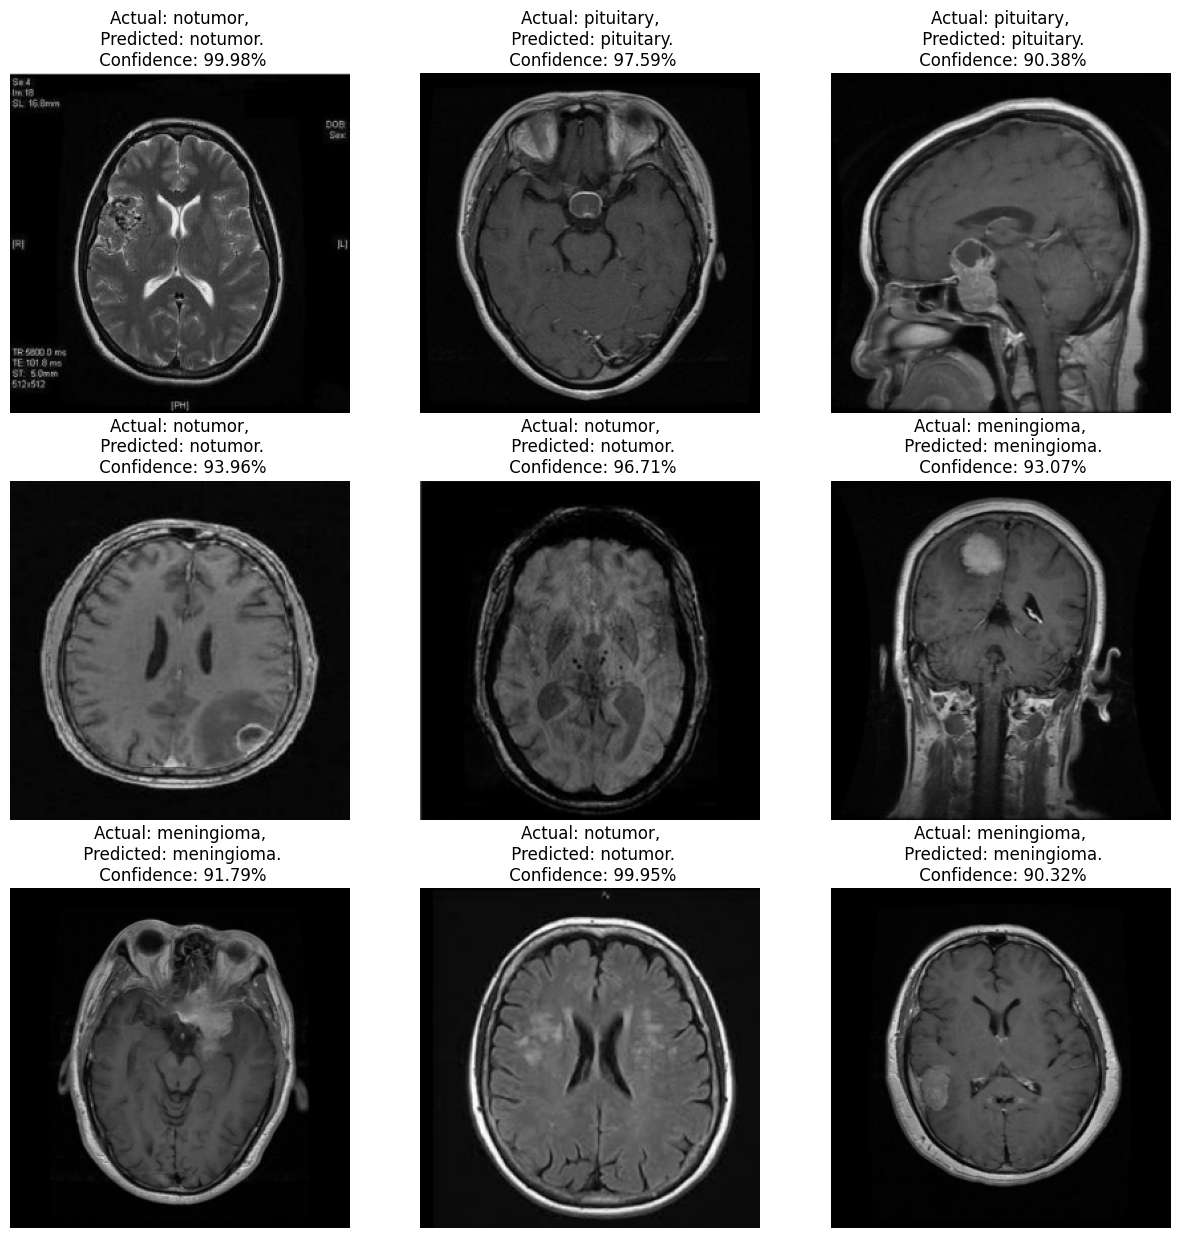

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 0s 62ms/step


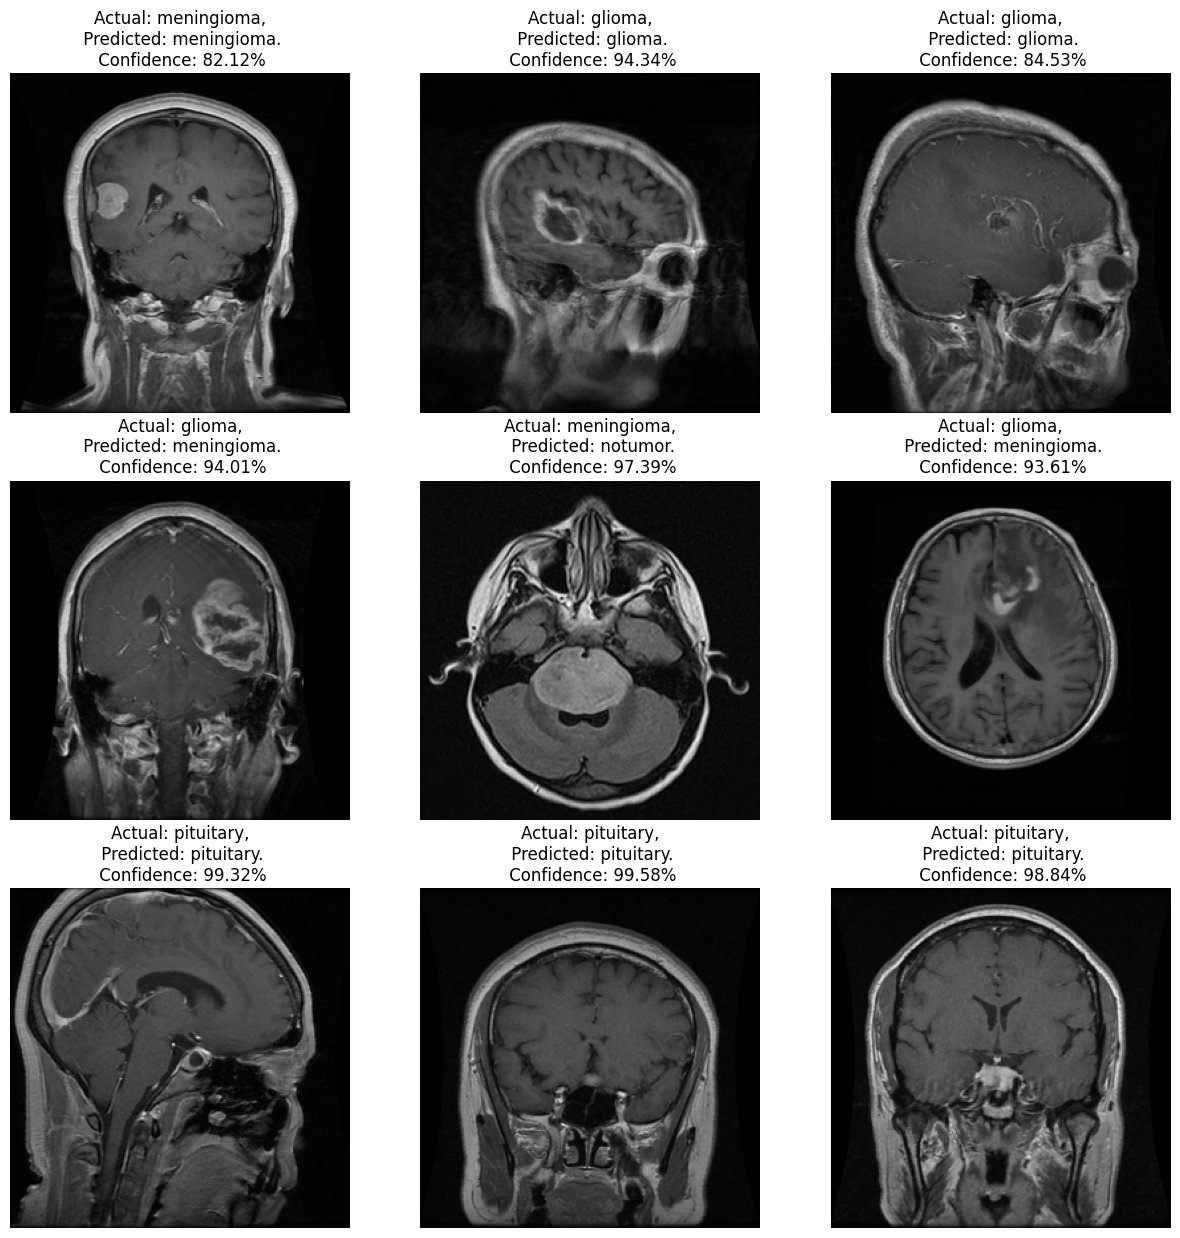

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")